In [2]:
import os
import json
import numpy as np
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances
import skimage.io
from pycocotools import mask as mask_utils
import numpy as np
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Path to the dataset
DATASET_DIR = "D:/graduate/mie1075/img_seg/d2s_dataset"

# Path to pre-trained COCO weights
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints
LOGS_DIR = os.path.join(ROOT_DIR, "logs")


# 1. Define Configuration for D2S Dataset
class D2SConfig(Config):
    """Configuration for training on the D2S dataset."""
    NAME = "d2s"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2  # Adjust based on GPU memory
    NUM_CLASSES = 1 + 60  # Background + 10 grocery classes
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 10
    DETECTION_MIN_CONFIDENCE = 0.7
    LEARNING_RATE = 0.001  # Learning rate
    BACKBONE = "resnet50"  # Backbone architecture
    IMAGE_MIN_DIM = 1200  # Minimum image dimension
    IMAGE_MAX_DIM = 2000  # Maximum image dimension
    RUN_EAGERLY = True


# 2. Dataset Class
class D2SDataset(utils.Dataset):
    def load_d2s(self, annotation_path, images_dir):
        """Load the D2S dataset."""
        with open(annotation_path) as f:
            data = json.load(f)

        # Add classes
        for category in data['categories']:
            self.add_class("d2s", category['id'], category['name'])

        # Add images and annotations
        for image in data['images']:
            image_id = image['id']
            image_path = os.path.join(images_dir, image['file_name'])
            annotations = [a for a in data['annotations'] if a['image_id'] == image_id]
            self.add_image(
                "d2s",
                image_id=image_id,
                path=image_path,
                width=image['width'],
                height=image['height'],
                annotations=annotations,
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image."""
        image_info = self.image_info[image_id]
        if image_info["source"] != "d2s":
            return super(self.__class__, self).load_mask(image_id)

        annotations = image_info["annotations"]
        masks = np.zeros((image_info["height"], image_info["width"], len(annotations)), dtype=np.uint8)
        class_ids = []

        for i, annotation in enumerate(annotations):
            mask = self.ann_to_mask(annotation, image_info["height"], image_info["width"])
            masks[:, :, i] = mask
            class_ids.append(annotation["category_id"])

        return masks, np.array(class_ids, dtype=np.int32)

    def ann_to_mask(self, annotation, height, width):
        """Convert annotation to binary mask."""
        mask = np.zeros((height, width), dtype=np.uint8)

        # Handle RLE-encoded segmentation
        if isinstance(annotation["segmentation"], dict):  # RLE format
            rle = annotation["segmentation"]
            mask = mask_utils.decode(rle)
            return mask

        # Handle polygon format
        for segmentation in annotation["segmentation"]:
            if len(segmentation) < 6:  # Skip invalid polygons
                print(f"Skipping invalid segmentation: {segmentation}")
                continue
            coords = np.array(segmentation).reshape((-1, 2)).astype(np.int32)
            cv2.fillPoly(mask, [coords], 1)
        return mask

In [8]:
annotation_path=os.path.join(DATASET_DIR, "annotations\D2S_training.json")
f = open(annotation_path)
data = json.load(f)
categories= data["categories"]


In [2]:
config = D2SConfig()
config.display()

# Datasets
dataset_train = D2SDataset()
dataset_train.load_d2s(
    annotation_path=os.path.join(DATASET_DIR, "annotations\D2S_training.json"),
    images_dir=os.path.join(DATASET_DIR, "train")
)
dataset_train.prepare()

dataset_val = D2SDataset()
dataset_val.load_d2s(
    annotation_path=os.path.join(DATASET_DIR, "annotations\D2S_validation.json"),
    images_dir=os.path.join(DATASET_DIR, "train")
    )
dataset_val.prepare()

# Model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIR)

# Load weights (COCO pre-trained)
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# Training
print("Training the model...")
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers="heads"
)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                73
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

Loading weights from: d:\graduate\mie1075\img_seg\best.h5
(1440, 1920, 3)
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1920, 1920, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 73)               min:    0.00000  max: 1920.00000  int32
anchors                  shape: (1, 920700, 4)        min:   -0.18866  max:    1.15531  float32


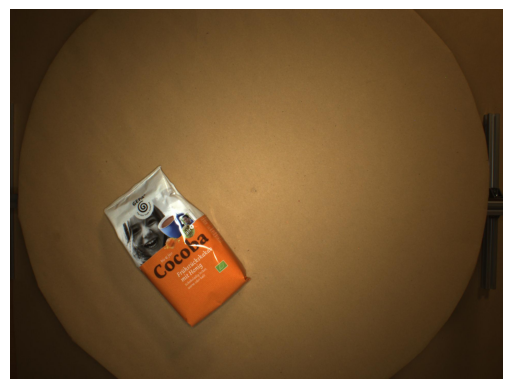

In [9]:
import matplotlib.pyplot as plt
class InferenceConfig(D2SConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    NUM_CLASSES = 1 + 60  # Background + 10 grocery classes
    IMAGE_MIN_DIM = 1440  # Minimum image dimension
    IMAGE_MAX_DIM = 1920  # Maximum image dimension
model_path = os.path.join(ROOT_DIR, "best.h5")
inference_config = InferenceConfig()

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="logs")

print("Loading weights from:", model_path)
model.load_weights(model_path, by_name=True)
image_path = "D:/graduate/mie1075/img_seg/d2s_dataset/train/D2S_000705.jpg"

image = skimage.io.imread(image_path)
#image = skimage.transform.resize(image, (1440/2, 1920/2), mode='reflect', anti_aliasing=True)
print(image.shape)
# Perform inference
results = model.detect([image], verbose=1)
r = results[0]
class_names=['BG']
for category in categories:
    class_names.append(f"ID: {category['id']}, Name: {category['name']}")

plt.imshow(image)
plt.axis("off")  # Turn off axis labels

plt.show()

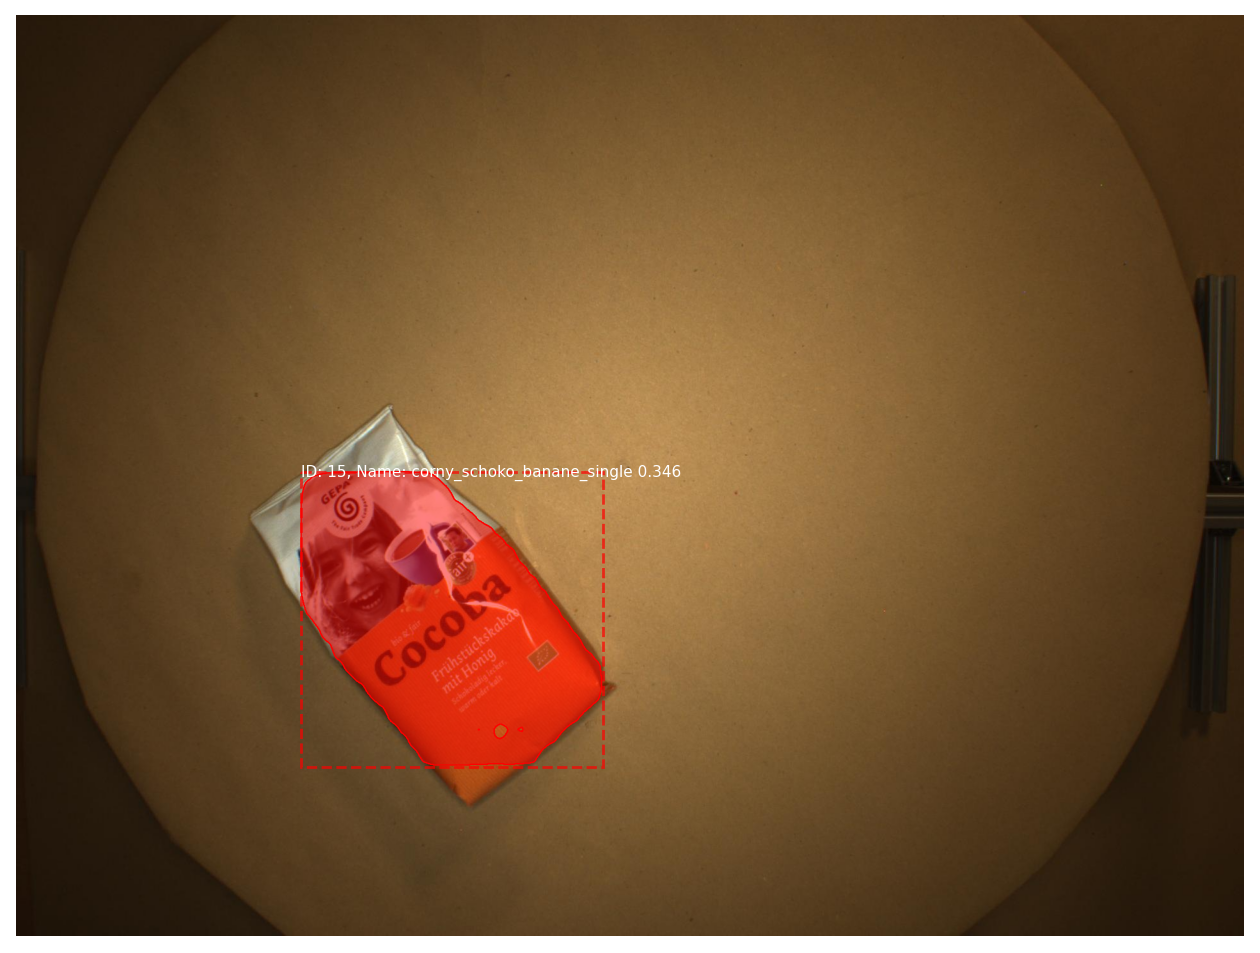

In [17]:
display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])